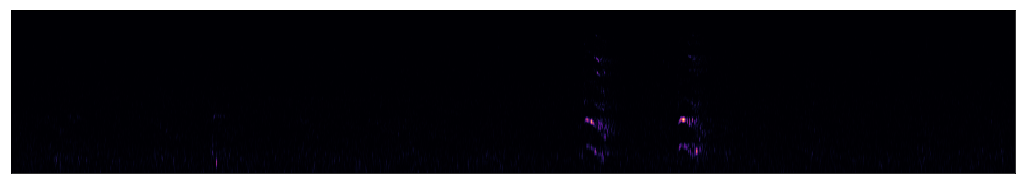

In [2]:
import h5py
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
sys.path.append("../src")

import localmodule

data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
full_pcen_name = "_".join([dataset_name, "full-pcen"])
full_pcen_dir = os.path.join(data_dir, full_pcen_name)
units = localmodule.get_units()
clip_pcen_name = "_".join([dataset_name, "clip-pcen"])
clip_pcen_dir = os.path.join(data_dir, clip_pcen_name)
aug_str = "original"
original_dir = os.path.join(clip_pcen_dir, aug_str)

unit_id = 0
unit_str = units[unit_id]
full_unit_path = os.path.join(full_pcen_dir, unit_str + ".hdf5")
full_unit_file = h5py.File(full_unit_path, "r")
full_pcen_group = full_unit_file["pcen"]
clip_pcen_name = "_".join([
dataset_name, aug_str, unit_str]) + ".hdf5"
clip_pcen_path = os.path.join(original_dir, clip_pcen_name)


full_pcen_stop = int(full_pcen_group.shape[1] - 1) 
full_pcen_start = full_pcen_stop - 10000
full_pcen = full_pcen_group[:, full_pcen_start:full_pcen_stop]

%matplotlib inline
plt.figure(figsize=(18,3))
#librosa.display.specshow(np.log1p(1000000*full_pcen))
librosa.display.specshow(full_pcen)

full_unit_file.close()

In [3]:
clip_pcen_file = h5py.File(clip_pcen_path)
clip_pcen_group = clip_pcen_file["pcen"]

negatives = []
positives = []

for key in list(clip_pcen_group.keys()):
    if key.split("_")[3] == "0":
        negatives.append(clip_pcen_group[key][:,172])
    elif key.split("_")[3] == "1":
        positives.append(clip_pcen_group[key][:,172])

negatives = np.stack(negatives, axis=1)
positives = np.stack(positives, axis=1)

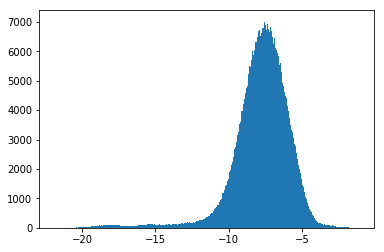

In [58]:
plt.hist(np.log(np.ravel(full_pcen)), bins=1000);

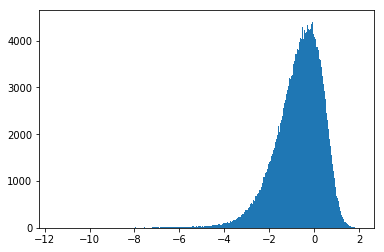

In [4]:
clip_pcens = np.concatenate((negatives, positives), axis=1);
plt.figure();
plt.hist(np.log(np.ravel(clip_pcens)), bins=1000);

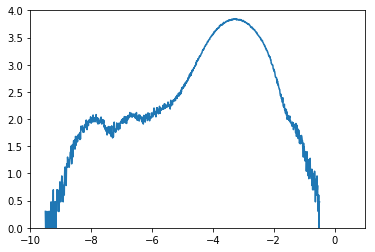

In [41]:
(x,y) = np.histogram(np.log10(np.ravel(full_pcen)), bins=1000)
plt.plot(y[:-1], np.log10(1+x));
plt.xlim(-10, 1);
plt.ylim(0, 4.0);

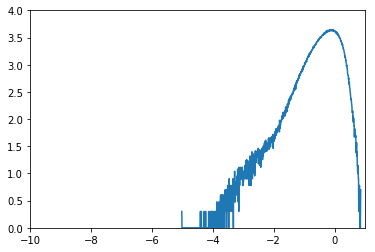

In [42]:
(x,y) = np.histogram(np.log10(np.ravel(clip_pcens)), bins=1000)
plt.plot(y[:-1], np.log10(1+x));
plt.xlim(-10, 1);
plt.ylim(0, 4.0);

In [46]:
import datetime
import h5py
import librosa
import numpy as np
import os
import pandas as pd
import soundfile as sf
import sys
import time

import localmodule


# Define constants.
data_dir = localmodule.get_data_dir()
dataset_name = localmodule.get_dataset_name()
pcen_settings = localmodule.get_pcen_settings()
sample_rate = localmodule.get_sample_rate()
chunk_duration = pcen_settings["hop_length"] # in seconds
chunk_length = chunk_duration * sample_rate


# Define PCEN smoother.
def pcen_smooth(melspec, time_constant_frames):
    smoothed_melspec = melspec.copy()
    coeff = 1.0 / time_constant_frames
    num_cols = melspec.shape[1]
    for col in np.arange(1, num_cols):
        smoothed_melspec[:, col] =\
            smoothed_melspec[:, col - 1] +\
            (melspec[:, col] - smoothed_melspec[:, col - 1]) * coeff
    return smoothed_melspec


# Print header.
start_time = int(time.time())
print(str(datetime.datetime.now()) + " Start.")
print("Computing PCEN for full " + dataset_name + ".")
print("Unit: " + unit_str + ".")
print("")
print("h5py version: {:s}".format(h5py.__version__))
print("librosa version: {:s}".format(librosa.__version__))
print("numpy version: {:s}".format(np.__version__))
print("pandas version: {:s}".format(pd.__version__))
print("soundfile version: {:s}".format(sf.__version__))
print("")


# Load GPS coordinates.
gps_name = "_".join([dataset_name, "gps-coordinates.csv"])
gps_path = os.path.join(data_dir, gps_name)
gps_df = pd.read_csv(gps_path)
gps_row = gps_df.loc[gps_df["Unit"] == unit_str].iloc[0]


# Load UTC starting times.
utc_name = "_".join([dataset_name, "utc-start-times.csv"])
utc_path = os.path.join(data_dir, utc_name)
utc_df = pd.read_csv(utc_path)
utc_row = utc_df.loc[utc_df["Unit"] == unit_str].iloc[0]


# Open full audio file as FLAC.
recordings_name = "_".join([dataset_name, "full-audio"])
recordings_dir = os.path.join(data_dir, recordings_name)
recording_name = unit_str + ".flac"
recording_path = os.path.join(recordings_dir, recording_name)
full_audio = sf.SoundFile(recording_path)
full_audio_length = len(full_audio)


# Compute number of chunks and number of hops.
n_chunks = int(np.ceil(full_audio_length / chunk_length))
pcen_hop_length = pcen_settings["hop_length"]
pcen_sr = pcen_settings["sr"]
n_samples_per_hop = pcen_hop_length * sample_rate / pcen_sr
n_hops = int(np.floor(full_audio_length / n_samples_per_hop))


# Start HDF5 group for per-channel energy normalization (PCEN) spectrograms.
pcen_dataset_size = (pcen_settings["n_mels"], n_hops)


chunk_id = 0

# Load audio chunk.
chunk_start = chunk_id * chunk_length
chunk_stop = min(chunk_start + chunk_length, full_audio_length)
full_audio.seek(chunk_start)
chunk_waveform = full_audio.read(chunk_stop-chunk_start)

# Resample to 22050 Hz.
chunk_waveform = librosa.resample(
    chunk_waveform, sample_rate, pcen_settings["sr"])

# Compute Short-Term Fourier Transform (STFT).
stft = librosa.stft(
    chunk_waveform,
    n_fft=pcen_settings["n_fft"],
    win_length=pcen_settings["win_length"],
    hop_length=pcen_settings["hop_length"],
    window=pcen_settings["window"])

# Delete last sample to compensate for padding.
stft = stft[:, :-1]

# Compute squared magnitude coefficients.
abs2_stft = (stft.real*stft.real) + (stft.imag*stft.imag)

# Gather frequency bins according to the Mel scale.
melspec = librosa.feature.melspectrogram(
    y=None,
    S=abs2_stft,
    sr=pcen_settings["sr"],
    n_fft=pcen_settings["n_fft"],
    n_mels=pcen_settings["n_mels"],
    htk=True,
    fmin=pcen_settings["fmin"],
    fmax=pcen_settings["fmax"])

# Smooth mel-spectrogram.
smoothed_melspec =\
    pcen_smooth(melspec, pcen_settings["pcen_time_constant_frames"])

# Apply adaptive gain factor.
pcen_gain = (smoothed_melspec + 1) ** pcen_settings["pcen_norm_exponent"]
pcen_melspec = melspec * pcen_gain

# Raise to PCEN exponent.
pcen_offset = pcen_melspec.max() / 10.0
pcen =\
    (pcen_melspec + pcen_offset) ** pcen_settings["pcen_power"] -\
    pcen_offset ** pcen_settings["pcen_power"]

# Convert to single floating-point precision.
pcen = pcen.astype('float32')

2017-12-12 17:42:14.716261 Start.
Computing PCEN for full BirdVox-70k.
Unit: unit01.

h5py version: 2.6.0
librosa version: 0.5.1
numpy version: 1.13.1
pandas version: 0.20.3
soundfile version: 0.9.0



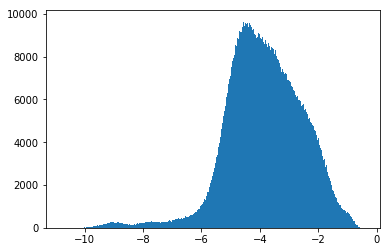

In [55]:
plt.hist(np.ravel(np.log10(melspec)), bins=1000);

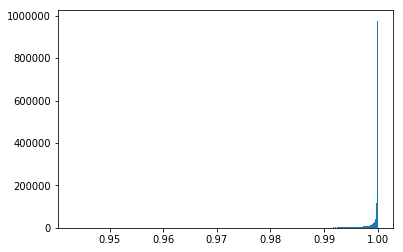

In [58]:
plt.hist(np.ravel(pcen_gain), bins=1000);